In [1]:
# Initialization

import math
from datetime import datetime
import openpyxl as opxl
from openpyxl.utils.dataframe import dataframe_to_rows
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import model as ty
import proc as pr
import matplotlib.ticker as mtick
import sklearn.metrics

from IPython.core.display import HTML

import heat_transfer as bht

import fluids as fds
import ht 

import general as gen

import os

import scipy.integrate as integrate
import scipy.optimize as sco

import networkx as nx

import plotly.graph_objects as go

import plot_functions_here as pfun

import plotly.io as pio

In [2]:
folder_path = r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-perf-1Dmodel'
geometry_path = folder_path + '\\' + 'Inputs\\Inputs_TEST_GMI.xlsx'
hypotheses_path = folder_path + '\\' + 'Hypotheses\\Model_hypotheses.xlsx'
condi_path = folder_path + '\\' + 'Steady-state conditions inputs\\100424-tests-conditions-GMI.xlsx'

output_name = 'TEST_n1'

componentSpecs = pr.import_geometry(geometry_path)
hyp = pr.create_dict_from_excel(hypotheses_path,'Main')
steadyStateConditions_df = pd.read_excel(condi_path,header=2) ## Les deux première lignes ne sont pas à prendre

In [23]:

stepConditions = steadyStateConditions_df.to_dict(orient='records')
stepConditions[1]


{'Case': 'Normal_CESIFroid_v1',
 'G': 800,
 'T_amb': 298.15,
 'T_back': 273.15,
 'u': 1e-05,
 'u_back': 0,
 'T_fluid_in0': 293.15,
 'Gp': 4,
 'T_sky': 273.15,
 'T_back_rad': 273.15,
 'mdot': 0.0478,
 'guess_T_PV': 270}

In [ ]:
# stepConditions = ty.write_stepConditions_from_steadyStateConditions(steadyStateConditions_df,0,hyp)

In [34]:
stepConditions =   {'G': 0.,
                    'T_amb': 273.15,
                    'T_back': 273.15,
                    'u': 0.00001,
                    'u_back': 0.,
                    'T_fluid_in0': 267.15,
                    'Gp': 4,
                    'T_sky': 273.15,
                    'T_back_rad': 273.15,
                    'mdot': 0.0478,
                    'guess_T_PV': 270.}

In [ ]:
# slices_df,df_one,its_df_list = ty.simu_one_steady_state(par,par_p,hyp)

In [4]:
df_one,res = ty.simu_one_steady_state_all_he(componentSpecs,stepConditions[0],hyp)

In [6]:
pr.disp_html(res['main']['df_one'])
pr.disp_html(df_one)
res['main']['its_data_list']


,G,Gp,T_amb,T_sky,T_back,T_back_rad,u,mdot,T_fluid_in,h_rad_f,h_top_g,h_back,h_rad_back,h_back_tube,h_rad_back_tube,h_back_fins,T_PV,T_fluid_out,T_tube_mean,T_glass,h_fluid,h_rad,X_celltemp,eta_PV,S,T_fluid_mean,T_Base_mean,T_absfin_mean,T_abs_mean,Qdot_tube_back,Qdot_absfin_back,T_ins_tube_mean,T_ins_absfin_mean,T_ins_mean,T_PV_Base_mean,T_PV_absfin_mean,Qdot_top_conv,Qdot_top_rad,Qdot_sun_glass,Qdot_sun_PV,Qdot_glass_PV,Qdot_PV_sky,Qdot_PV_plate,Qdot_PV_Base,Qdot_PV_absfin,Qdot_Base_back,Qdot_tube_fluid,Qdot_tube_sky,Qdot_Base_tube,Qdot_absfin_Base,Qdot_absfin_back_conv,Qdot_absfin_back_rad,Qdot_tube_back_conv,Qdot_tube_back_rad,Qdot_ins_tube_back_conv,Qdot_ins_tube_back_rad,Qdot_ins_absfin_back_conv,Qdot_ins_absfin_back_rad,Qdot_f01
0,0.0,4,273.15,273.15,273.15,273.15,0.00001,0.0478,267.15,0.0,1.783133,3.08297,3.613087,3.08297,3.613007,3.08297,269.122273,269.093796,268.933881,269.180364,167.671122,4.068851,1.098694,0.0,0.0,268.185155,268.935594,268.939722,268.937904,-151.483235,-30.52861,268.933881,268.939722,268.937149,269.120064,269.124015,-13.70993,-31.296148,0.0,0.0,45.006078,-31.741884,76.747962,33.858051,42.890898,0.0,336.813024,-45.698606,107.276607,73.418556,-14.055852,-16.472758,-69.746095,-81.73714,-69.746095,-81.73714,-14.055852,-16.472758,0.0


,G,Gp,T_amb,T_sky,T_back,T_back_rad,u,mdot,T_fluid_in,h_rad_f,h_top_g,h_back,h_rad_back,h_back_tube,h_rad_back_tube,h_back_fins,T_PV,T_fluid_out,T_tube_mean,T_glass,h_fluid,h_rad,X_celltemp,eta_PV,S,T_fluid_mean,T_Base_mean,T_absfin_mean,T_abs_mean,Qdot_tube_back,Qdot_absfin_back,T_ins_tube_mean,T_ins_absfin_mean,T_ins_mean,T_PV_Base_mean,T_PV_absfin_mean,Qdot_top_conv,Qdot_top_rad,Qdot_sun_glass,Qdot_sun_PV,Qdot_glass_PV,Qdot_PV_sky,Qdot_PV_plate,Qdot_PV_Base,Qdot_PV_absfin,Qdot_Base_back,Qdot_tube_fluid,Qdot_tube_sky,Qdot_Base_tube,Qdot_absfin_Base,Qdot_absfin_back_conv,Qdot_absfin_back_rad,Qdot_tube_back_conv,Qdot_tube_back_rad,Qdot_ins_tube_back_conv,Qdot_ins_tube_back_rad,Qdot_ins_absfin_back_conv,Qdot_ins_absfin_back_rad,Qdot_f01
0,0.0,4,273.15,273.15,273.15,273.15,0.00001,0.0478,267.15,0.0,1.783133,3.08297,3.613087,3.08297,3.613007,3.08297,269.122273,269.093796,268.933881,269.180364,167.671122,4.068851,1.098694,0.0,0.0,268.185155,268.935594,268.939722,268.937904,-151.483235,-30.52861,268.933881,268.939722,268.937149,269.120064,269.124015,-13.70993,-31.296148,0.0,0.0,45.006078,-31.741884,76.747962,33.858051,42.890898,0.0,336.813024,-45.698606,107.276607,73.418556,-14.055852,-16.472758,-69.746095,-81.73714,-69.746095,-81.73714,-14.055852,-16.472758,0.0


[     G  Gp   T_amb   T_sky  T_back  T_back_rad        u    mdot  T_fluid_in  \
 0  0.0   4  273.15  273.15  273.15      273.15  0.00001  0.0478      267.15   
 1  0.0   4  273.15  273.15  273.15      273.15  0.00001  0.0478      267.15   
 2  0.0   4  273.15  273.15  273.15      273.15  0.00001  0.0478      267.15   
 3  0.0   4  273.15  273.15  273.15      273.15  0.00001  0.0478      267.15   
 4  0.0   4  273.15  273.15  273.15      273.15  0.00001  0.0478      267.15   
 
    Slice  ...  Qdot_tube_back_conv  Qdot_tube_back_rad  \
 0      0  ...            -1.643959           -1.842364   
 1      0  ...            -1.389286           -1.629924   
 2      0  ...            -1.395060           -1.634861   
 3      0  ...            -1.394918           -1.634740   
 4      0  ...            -1.394922           -1.634743   
 
    Qdot_ins_tube_back_conv  Qdot_ins_tube_back_rad  Qdot_ins_absfin_back_conv  \
 0                -1.643959               -1.842364                  -0.331454  

In [55]:
for part in componentSpecs['decomp'].keys():
    bal,bal_perc = ty.recap_energy_balances(res[part]['df_one'])
    print(part,bal_perc)
bal,bal_perc = ty.recap_energy_balances(df_one)
print('Total',bal_perc)

main {'glass': 0   -1.692855e-13
dtype: float64, 'PV': 0   -0.000015
dtype: float64, 'Base': 0    1.312290e-11
dtype: float64, 'absfin': 0    0.000014
dtype: float64, 'tube': 0   -0.479976
dtype: float64}
Total {'glass': 0   -1.141132e-11
dtype: float64, 'PV': 0   -0.000988
dtype: float64, 'Base': 0    8.845973e-10
dtype: float64, 'absfin': 0    0.000952
dtype: float64, 'tube': 0   -32.354576
dtype: float64}


In [9]:
merged_df = pd.concat([df_one] + [res[part]['df_one'] for part in res.keys()], axis=0)
merged_df.insert(0, 'Component', ['Total']+ list(componentSpecs['decomp'].keys()))
merged_df.insert(1, 'Component name', ['Total']+ list(componentSpecs['decomp'].values()))

In [10]:
pr.disp_html(merged_df)

,Component,Component name,G,Gp,T_amb,T_sky,T_back,T_back_rad,u,mdot,T_fluid_in,h_rad_f,h_top_g,h_back,h_rad_back,h_back_tube,h_rad_back_tube,h_back_fins,T_PV,T_fluid_out,T_tube_mean,T_glass,h_fluid,h_rad,X_celltemp,eta_PV,S,T_fluid_mean,T_Base_mean,T_absfin_mean,T_abs_mean,Qdot_tube_back,Qdot_absfin_back,T_ins_tube_mean,T_ins_absfin_mean,T_ins_mean,T_PV_Base_mean,T_PV_absfin_mean,Qdot_top_conv,Qdot_top_rad,Qdot_sun_glass,Qdot_sun_PV,Qdot_glass_PV,Qdot_PV_sky,Qdot_PV_plate,Qdot_PV_Base,Qdot_PV_absfin,Qdot_Base_back,Qdot_tube_fluid,Qdot_tube_sky,Qdot_Base_tube,Qdot_absfin_Base,Qdot_absfin_back_conv,Qdot_absfin_back_rad,Qdot_tube_back_conv,Qdot_tube_back_rad,Qdot_ins_tube_back_conv,Qdot_ins_tube_back_rad,Qdot_ins_absfin_back_conv,Qdot_ins_absfin_back_rad,Qdot_f01
0,Total,Total,0.0,4.0,273.15,273.15,273.15,273.15,0.00001,0.0478,267.15,0.0,1.783133,3.08297,3.613087,3.08297,3.613007,3.08297,269.122273,269.093796,268.933881,269.180364,167.671122,4.068851,1.098694,0.0,0.0,268.185155,268.935594,268.939722,268.937904,-151.483235,-30.52861,268.933881,268.939722,268.937149,269.120064,269.124015,-13.70993,-31.296148,0.0,0.0,45.006078,-31.741884,76.747962,33.858051,42.890898,0.0,336.813024,-45.698606,107.276607,73.418556,-14.055852,-16.472758,-69.746095,-81.73714,-69.746095,-81.73714,-14.055852,-16.472758,0.0
0,main,HX_6,0.0,4.0,273.15,273.15,273.15,273.15,0.00001,0.0478,267.15,0.0,1.783133,3.08297,3.613087,3.08297,3.613007,3.08297,269.122273,269.093796,268.933881,269.180364,167.671122,4.068851,1.098694,0.0,0.0,268.185155,268.935594,268.939722,268.937904,-151.483235,-30.52861,268.933881,268.939722,268.937149,269.120064,269.124015,-13.70993,-31.296148,0.0,0.0,45.006078,-31.741884,76.747962,33.858051,42.890898,0.0,336.813024,-45.698606,107.276607,73.418556,-14.055852,-16.472758,-69.746095,-81.73714,-69.746095,-81.73714,-14.055852,-16.472758,0.0


In [11]:
df_one['T_PV']

0    269.122273
Name: T_PV, dtype: float64

In [12]:
A1 = ( - df_one['Qdot_tube_fluid'] / componentSpecs['AG'] / ( (df_one['T_fluid_out'] + df_one['T_fluid_in'])/2 - df_one['T_amb'] ) ).values[0]
print('A1',A1)

A1 34.58468846785098


In [13]:
bal,bal_perc = ty.recap_energy_balances(res['main']['df_one'])

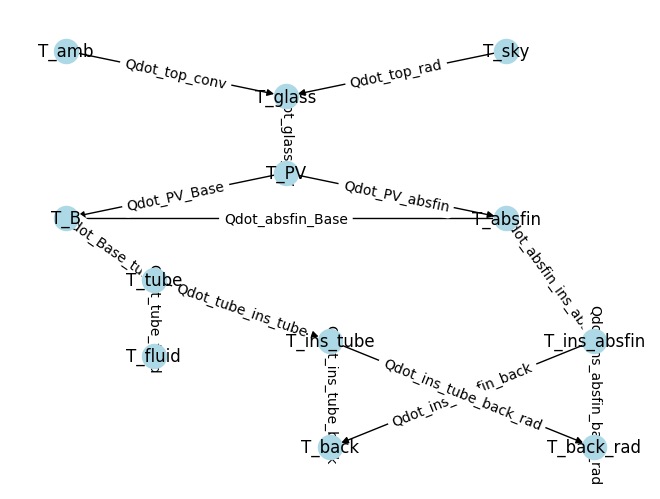

In [75]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ['T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_B', 'T_absfin', 
         'T_tube', 'T_fluid', 'T_ins_absfin', 'T_ins_tube', 'T_back', 'T_back_rad']
G.add_nodes_from(nodes)

# Add edges with labels
edges = [('T_amb', 'T_glass', 'Qdot_top_conv'), ('T_sky', 'T_glass', 'Qdot_top_rad'),
         ('T_glass', 'T_PV', 'Qdot_glass_PV'), ('T_PV', 'T_B', 'Qdot_PV_Base'),
         ('T_PV', 'T_absfin', 'Qdot_PV_absfin'), ('T_absfin', 'T_B', 'Qdot_absfin_Base'),
         ('T_B', 'T_tube', 'Qdot_Base_tube'), ('T_tube', 'T_fluid', 'Qdot_tube_fluid'),
         ('T_absfin', 'T_ins_absfin', 'Qdot_absfin_ins_absfin'),
         ('T_tube', 'T_ins_tube', 'Qdot_tube_ins_tube'),
         ('T_ins_absfin', 'T_back', 'Qdot_ins_absfin_back'),
         ('T_ins_absfin', 'T_back_rad', 'Qdot_ins_absfin_back_rad'),
         ('T_ins_tube', 'T_back', 'Qdot_ins_tube_back'),
         ('T_ins_tube', 'T_back_rad', 'Qdot_ins_tube_back_rad')]

for u, v, label in edges:
    G.add_edge(u, v, label=label)

# Manually set positions based on TikZ coordinates
pos = {
    'T_amb': (3, 0),
    'T_sky': (8, 0),
    'T_glass': (5.5, -3),
    'T_PV': (5.5, -8),
    'T_B': (3, -11),
    'T_absfin': (8, -11),
    'T_tube': (4, -15),
    'T_fluid': (4, -20),
    'T_ins_absfin': (9, -19),
    'T_ins_tube': (6, -19),
    'T_back': (6, -26),
    'T_back_rad': (9, -26)
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.savefig('GrapheOriente.png', format='png')

plt.show()


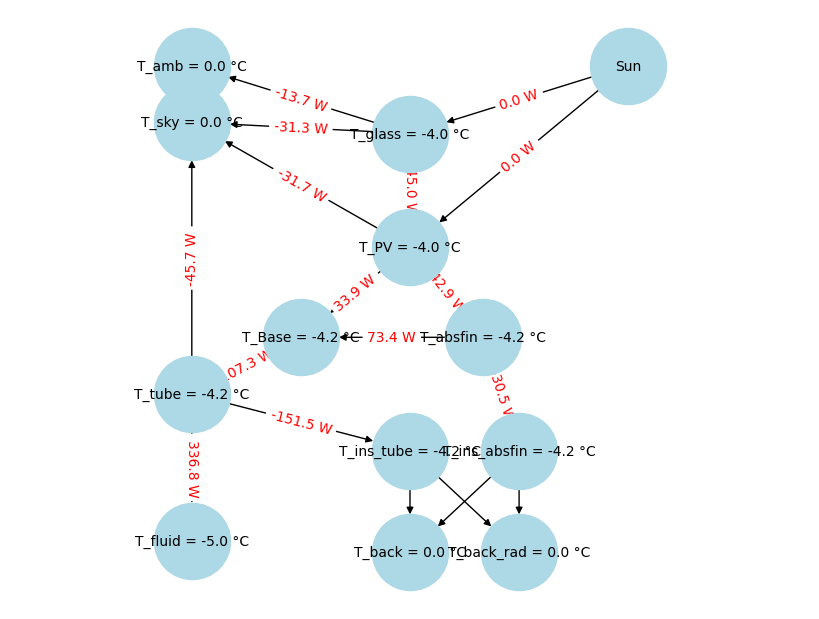

In [15]:
pfun.plot_graph(df_one)

In [16]:
ht_signs = {'Qdot_sun_PV':1, 'Qdot_sun_glass':1, 'Qdot_top_conv':-1, 'Qdot_top_rad':-1, 'Qdot_PV_sky':-1, 'Qdot_absfin_back_conv':-1, 'Qdot_absfin_back_rad':-1, 'Qdot_Base_back':-1, 'Qdot_tube_back_conv':-1, 'Qdot_tube_back_rad':-1, 'Qdot_tube_sky':-1}
ht_labels = ['Qdot_sun_PV', 'Qdot_sun_glass', 'Qdot_top_conv', 'Qdot_top_rad', 'Qdot_PV_sky', 'Qdot_absfin_back_conv', 'Qdot_absfin_back_rad', 'Qdot_Base_back', 'Qdot_tube_back_conv', 'Qdot_tube_back_rad', 'Qdot_tube_sky']
data = {key:ht_signs[key]*df_one[key].values[0] for key in ht_labels}

# Adjusted approach for a single-column histogram with offset bars
fig = go.Figure()

# Initialize cumulative sums for positive and negative values
cumulative_positive = 0
cumulative_negative = 0

for key, value in data.items():
    if value >= 0:
        # For positive values, start from the last positive cumulative sum
        base = cumulative_positive
        cumulative_positive += value
    else:
        # For negative values, start from the last negative cumulative sum
        base = cumulative_negative
        cumulative_negative += value
    
    fig.add_trace(go.Bar(
        x=["Heat Transfer Contributions"],
        y=[value],
        name=key,
        width=0.2,
        base=base  # Set the starting point of the bar
    ))

# Update the layout
fig.update_layout(
    title="Decomposition of Qdot_tube_fluid in Different Heat Transfer Contributions",
    yaxis_title="Value",
    barmode="overlay"  # Overlay the bars
)

# Show the figure
fig.show()


In [36]:
ht_signs = {'Qdot_sun_PV': 1, 'Qdot_sun_glass': 1, 'Qdot_top_conv': -1, 'Qdot_top_rad': -1, 'Qdot_PV_sky': -1, 'Qdot_absfin_back_conv': -1, 'Qdot_absfin_back_rad': -1, 'Qdot_Base_back': -1, 'Qdot_tube_back_conv': -1, 'Qdot_tube_back_rad': -1, 'Qdot_tube_sky': -1}
ht_labels = ['Qdot_sun_PV', 'Qdot_sun_glass', 'Qdot_top_conv', 'Qdot_top_rad', 'Qdot_PV_sky', 'Qdot_absfin_back_conv', 'Qdot_absfin_back_rad', 'Qdot_Base_back', 'Qdot_tube_back_conv', 'Qdot_tube_back_rad', 'Qdot_tube_sky']
data = {key: ht_signs[key] * df_one[key].values[0] for key in ht_labels}

# Création du graphique en barres
fig = go.Figure()

# Ajout de chaque barre sur le graphique
for key, value in data.items():
    fig.add_trace(go.Bar(x=[key], y=[value], name=key))

# Ajout des annotations sous chaque barre
for i, key in enumerate(data.keys()):
    fig.add_annotation(
        x=key,
        y=data[key],
        text="",
        showarrow=False,
    )

# Personnalisation du titre et des étiquettes
fig.update_layout(
    title="Decomposition of Qdot_tube_fluid in Different Heat Transfer Contributions",
    yaxis_title="Value",
    barmode="group"  # Pour afficher les barres côte à côte
)

# Affichage du graphique
fig.show()


In [ ]:
125/5.65/1.93

In [19]:
res['main']['slices_df']['eta_PV']
pr.disp_html(res['main']['df_one'])

,G,Gp,T_amb,T_sky,T_back,T_back_rad,u,mdot,T_fluid_in,h_rad_f,h_top_g,h_back,h_rad_back,h_back_tube,h_rad_back_tube,h_back_fins,T_PV,T_fluid_out,T_tube_mean,T_glass,h_fluid,h_rad,X_celltemp,eta_PV,S,T_fluid_mean,T_Base_mean,T_absfin_mean,T_abs_mean,Qdot_tube_back,Qdot_absfin_back,T_ins_tube_mean,T_ins_absfin_mean,T_ins_mean,T_PV_Base_mean,T_PV_absfin_mean,Qdot_top_conv,Qdot_top_rad,Qdot_sun_glass,Qdot_sun_PV,Qdot_glass_PV,Qdot_PV_sky,Qdot_PV_plate,Qdot_PV_Base,Qdot_PV_absfin,Qdot_Base_back,Qdot_tube_fluid,Qdot_tube_sky,Qdot_Base_tube,Qdot_absfin_Base,Qdot_absfin_back_conv,Qdot_absfin_back_rad,Qdot_tube_back_conv,Qdot_tube_back_rad,Qdot_ins_tube_back_conv,Qdot_ins_tube_back_rad,Qdot_ins_absfin_back_conv,Qdot_ins_absfin_back_rad,Qdot_f01
0,0.0,4.0,273.15,273.15,273.15,273.15,0.00001,0.0478,267.15,0.0,1.783133,3.08297,3.613087,3.08297,3.613007,3.08297,269.122273,269.093796,268.933881,269.180364,167.671122,4.068851,1.098694,0.0,0.0,268.185155,268.935594,268.939722,268.937904,-151.483235,-30.52861,268.933881,268.939722,268.937149,269.120064,269.124015,-13.70993,-31.296148,0.0,0.0,45.006078,-31.741884,76.747962,33.858051,42.890898,0.0,336.813024,-45.698606,107.276607,73.418556,-14.055852,-16.472758,-69.746095,-81.73714,-69.746095,-81.73714,-14.055852,-16.472758,0.0


Affichages visuels

In [24]:
componentSpecs['main']['p_tube_sky']

0.0

In [25]:
df_one,res = ty.simu_one_steady_state_all_he(componentSpecs,stepConditions[0],hyp)

In [19]:
## df_one pour chaque résultat + résidus
df_one_html = df_one.to_html()

## Résidus
for part in componentSpecs['decomp'].keys():
    bal,bal_perc = ty.recap_energy_balances(res[part]['df_one'])
    print(part,bal_perc)
bal,bal_perc = ty.recap_energy_balances(df_one)
df = pd.DataFrame(bal_perc)
residus_html = df.to_html()

main {'glass': 0   -1.692855e-13
dtype: float64, 'PV': 0   -0.000015
dtype: float64, 'Base': 0    1.312290e-11
dtype: float64, 'absfin': 0    0.000014
dtype: float64, 'tube': 0   -0.479976
dtype: float64}


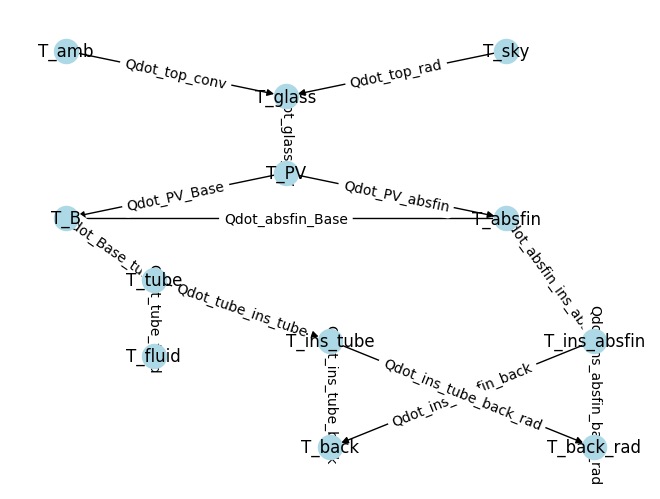

In [31]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ['T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_B', 'T_absfin', 
         'T_tube', 'T_fluid', 'T_ins_absfin', 'T_ins_tube', 'T_back', 'T_back_rad']
G.add_nodes_from(nodes)

# Add edges with labels
edges = [('T_amb', 'T_glass', 'Qdot_top_conv'), ('T_sky', 'T_glass', 'Qdot_top_rad'),
         ('T_glass', 'T_PV', 'Qdot_glass_PV'), ('T_PV', 'T_B', 'Qdot_PV_Base'),
         ('T_PV', 'T_absfin', 'Qdot_PV_absfin'), ('T_absfin', 'T_B', 'Qdot_absfin_Base'),
         ('T_B', 'T_tube', 'Qdot_Base_tube'), ('T_tube', 'T_fluid', 'Qdot_tube_fluid'),
         ('T_absfin', 'T_ins_absfin', 'Qdot_absfin_ins_absfin'),
         ('T_tube', 'T_ins_tube', 'Qdot_tube_ins_tube'),
         ('T_ins_absfin', 'T_back', 'Qdot_ins_absfin_back'),
         ('T_ins_absfin', 'T_back_rad', 'Qdot_ins_absfin_back_rad'),
         ('T_ins_tube', 'T_back', 'Qdot_ins_tube_back'),
         ('T_ins_tube', 'T_back_rad', 'Qdot_ins_tube_back_rad')]

for u, v, label in edges:
    G.add_edge(u, v, label=label)

# Manually set positions based on TikZ coordinates
pos = {
    'T_amb': (3, 0),
    'T_sky': (8, 0),
    'T_glass': (5.5, -3),
    'T_PV': (5.5, -8),
    'T_B': (3, -11),
    'T_absfin': (8, -11),
    'T_tube': (4, -15),
    'T_fluid': (4, -20),
    'T_ins_absfin': (9, -19),
    'T_ins_tube': (6, -19),
    'T_back': (6, -26),
    'T_back_rad': (9, -26)
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.savefig('GrapheOriente.png', format='png')


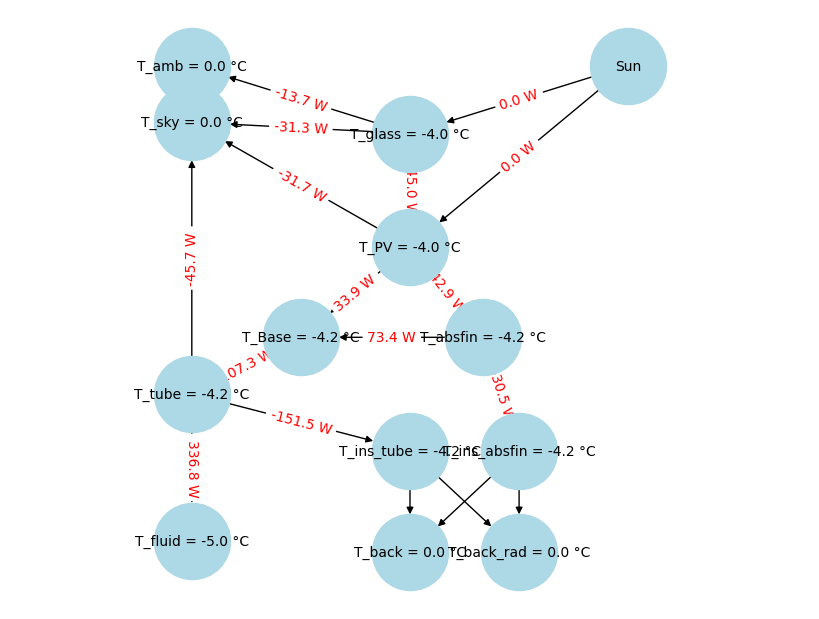

In [82]:
## Graphes noeufs températures et arêtes transferts
# Create a directed graph
G = nx.DiGraph()

# Add nodes with labels including temperature
nodes = ['Sun','T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_Base', 'T_absfin', 
        'T_tube', 'T_fluid', 'T_ins_absfin', 'T_ins_tube', 'T_back', 'T_back_rad']

nodes_keys = ['Sun','T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_Base_mean', 'T_absfin_mean',
                'T_tube_mean', 'T_fluid_mean', 'T_ins_absfin_mean', 'T_ins_tube_mean', 'T_back', 'T_back_rad']

for i,node in enumerate(nodes):
    if node == "Sun":
        G.add_node(node, label=node)
    else:
        G.add_node(node, label=f"{node} = {round(df_one[nodes_keys[i]].iloc[0]-273.15,1)} °C")

# Add edges with heat transfer labels
edges = [('Sun','T_glass','Qdot_sun_glass'),('Sun','T_PV','Qdot_sun_PV'),
            ('T_glass', 'T_amb', 'Qdot_top_conv'),('T_glass', 'T_sky', 'Qdot_top_rad'),
            ('T_glass', 'T_PV', 'Qdot_glass_PV'), ('T_PV', 'T_Base', 'Qdot_PV_Base'), ('T_PV', 'T_sky', 'Qdot_PV_sky'),
            ('T_PV', 'T_absfin', 'Qdot_PV_absfin'), ('T_absfin', 'T_Base', 'Qdot_absfin_Base'),
            ('T_Base', 'T_tube', 'Qdot_Base_tube'), ('T_tube', 'T_fluid', 'Qdot_tube_fluid'),('T_tube','T_sky','Qdot_tube_sky'),
            ('T_absfin', 'T_ins_absfin', 'Qdot_absfin_back'),
            ('T_tube', 'T_ins_tube', 'Qdot_tube_back'),
            ('T_ins_absfin', 'T_back', ''),
            ('T_ins_absfin', 'T_back_rad', ''),
            ('T_ins_tube', 'T_back', ''),
            ('T_ins_tube', 'T_back_rad', '')]

for u, v, label in edges:
    if label == '':
        G.add_edge(u, v)
    else:
        G.add_edge(u, v, label=f"{round(df_one[label].iloc[0],1)} W")

# Manually set positions based on TikZ coordinates
pos = {'Sun': (18,0),
        'T_amb': (6, 0),
        'T_sky': (6, -5),
        'T_glass': (12, -6),
        'T_PV': (12, -16),
        'T_Base': (9, -24),
        'T_absfin': (14, -24),
        'T_tube': (6, -29),
        'T_fluid': (6, -42),
        'T_ins_absfin': (15, -34),
        'T_ins_tube': (12, -34),
        'T_back': (12, -43),
        'T_back_rad': (15, -43)
    }

# Draw the graph with updated node labels
node_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

# Création de la figure avec une taille augmentée
plt.figure(figsize=(8, 6))  # Augmenter la taille selon le besoin

# Dessin du graphe avec les positions et étiquettes de nœuds personnalisées
nx.draw(G, pos, labels=node_labels, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Ajustement des limites des axes avec une marge supplémentaire
ax = plt.gca()  # Obtenir l'objet des axes courants
ax.set_xlim([min(x for x, _ in pos.values()) - 5, max(x for x, _ in pos.values()) + 5])  # Ajuster selon les valeurs x min et max des positions
ax.set_ylim([min(y for _, y in pos.values()) - 5, max(y for _, y in pos.values()) + 5])  # Ajuster selon les valeurs y min et max des positions

# Enregistrer la figure en HTML
plt.savefig('GrapheOrienteNumerique.png', format='png')

In [81]:
## Histogramme

ht_signs = {'Qdot_sun_PV': 1, 'Qdot_sun_glass': 1, 'Qdot_top_conv': -1, 'Qdot_top_rad': -1, 'Qdot_PV_sky': -1, 'Qdot_absfin_back_conv': -1, 'Qdot_absfin_back_rad': -1, 'Qdot_Base_back': -1, 'Qdot_tube_back_conv': -1, 'Qdot_tube_back_rad': -1, 'Qdot_tube_sky': -1}
ht_labels = ['Qdot_sun_PV', 'Qdot_sun_glass', 'Qdot_top_conv', 'Qdot_top_rad', 'Qdot_PV_sky', 'Qdot_absfin_back_conv', 'Qdot_absfin_back_rad', 'Qdot_Base_back', 'Qdot_tube_back_conv', 'Qdot_tube_back_rad', 'Qdot_tube_sky']
data = {key: ht_signs[key] * df_one[key].values[0] for key in ht_labels}

# Création du graphique en barres
fig = go.Figure()

# Ajout de chaque barre sur le graphique
for key, value in data.items():
    fig.add_trace(go.Bar(x=[key], y=[value], name=key))

# Ajout des annotations sous chaque barre
for i, key in enumerate(data.keys()):
    fig.add_annotation(
        x=key,
        y=data[key],
        text="",
        showarrow=False,
    )

# Personnalisation du titre et des étiquettes
fig.update_layout(
    title="Decomposition of Qdot_tube_fluid in Different Heat Transfer Contributions",
    yaxis_title="Value",
    barmode="group"  # Pour afficher les barres côte à côte
)

# Enregistrer le graphique en HTML
TransfertHTML = pio.write_html(fig, file='figure_plotly.html', auto_open=False)

In [78]:
## Température in, out, mean, PV 
# Données de température
Temperature = ['T_fluid_in', 'T_tube_mean', 'T_fluid_out', 'T_PV']
dataTemp = {key: df_one[key].values[0] - 273.15 for key in Temperature}

# Création du graphique en barres
fig = go.Figure()

# Ajout de chaque barre sur le graphique
for key, value in dataTemp.items():
    fig.add_trace(go.Bar(x=[key], y=[value], name=key))

# Ajout des annotations sous chaque barre
for i, key in enumerate(dataTemp.keys()):
    fig.add_annotation(
        x=key,
        y=dataTemp[key],
        text="",
        showarrow=False,
    )

# Personnalisation du titre et des étiquettes
fig.update_layout(
    title="Températures en °C",
    yaxis_title="Température (en°C)",
    barmode="group"  # Pour afficher les barres côte à côte
)

# Ajuster la plage de l'axe y pour adapter les barres à l'affichage
fig.update_yaxes(range=[min(dataTemp.values()) - 5, max(dataTemp.values()) + 5])

# Enregistrer le graphique en HTML
TemperatureHTML = pio.write_html(fig, file='TemperatureInOutMeanPV.html', auto_open=False)

In [186]:
## Profil des températures
# 𝑇𝑓𝑙𝑢𝑖𝑑(𝑦) = (𝑇𝑓𝑙𝑢𝑖𝑑,𝑖𝑛 + 𝑏𝑓/𝑎𝑓) exp(𝑎𝑓 𝑦) − 𝑏𝑓/𝑎𝑓
a_f = float(res['main']['slices_df']['a_f'].iloc[0])
b_f = float(res['main']['slices_df']['b_f'].iloc[0])
T_fluid_in = float(res['main']['slices_df']['T_fluid_in'].iloc[0])
L_tube = componentSpecs['main']['L_tube']

def T_fluid_fct(y_values, T_fluid_in, a_f, b_f):
    T_fluid_values = np.zeros(len(y_values))
    i=0
    for y in y_values:
        T_fluid_value = (T_fluid_in + b_f / a_f) * np.exp(a_f * y) - b_f / a_f
        T_fluid_values[i]= T_fluid_value -273.15
        i+=1
    return T_fluid_values

y_values = np.linspace(0, L_tube, 100)
T_fluid_values = T_fluid_fct(y_values, T_fluid_in, a_f, b_f)

# Tracé de la courbe avec Plotly
fig = go.Figure(go.Scatter(x=y_values, y=T_fluid_values))

# Ajuster la plage de l'axe y pour adapter les barres à l'affichage
fig.update_xaxes(range=[0, L_tube])

# Personnalisation du titre et des étiquettes
fig.update_layout(title='Profil de température au sein d\'un canal',
                  xaxis_title='Position y',
                  yaxis_title='Température en °C')

# Enregistrer le graphique en HTML
ProfilHTML = pio.write_html(fig, file='ProfilTemp.html', auto_open=True)


In [104]:
#Page HTML qui affiche les résultats pour 1 cas

# Récupération de la valeur 'Case' de stepConditions
case_value = stepConditions[17]['Case']

# Création du fichier HTML pour afficher tous les résultats
html_content = f"""
<div style="width: 800px; overflow-x: auto;">
<!DOCTYPE html>
<html>
<head>
    <title>Résultats</title>
</head>
<body>
    <h1>Résultats : {case_value} </h1>
    <h2>df_one</h2>
    <div style="overflow-x:auto;">
    {df_one_html}
    </div>
    
    <h2>Résidus</h2>
    {residus_html}
    </div>

    <h2>Graphes orientés des transferts</h2>
    <img src="GrapheOriente.png" alt="Graphe des noeuds températures et arêtes transferts">
    <br><br>
    <h2> </h2>
    <img src="GrapheOrienteNumerique.png" alt="Graphe des noeuds températures et arêtes transferts">
    <br><br>
    <h2>Histogramme du transfert de chaleur</h2>
    <iframe src="figure_plotly.html" width="800" height="600"></iframe>
    <br><br>
    <h2>Histogramme des température</h2>
    <iframe src="TemperatureInOutMeanPV.html" width="800" height="600"></iframe>
    <br><br>
    <h2>Profil des températures</h2>
    <iframe src="ProfilTemp.html" width="800" height="600"></iframe>
    <br><br>
</body>
</html>
</div>
"""

# Enregistrer le contenu dans un fichier HTML
with open('resultats.html', 'w') as file:
    file.write(html_content)

# Ouvrir le fichier HTML dans le navigateur
import webbrowser
webbrowser.open('resultats.html')


True

main {'glass': 0    3.343300e-13
dtype: float64, 'PV': 0   -0.000014
dtype: float64, 'Base': 0    2.182538e-11
dtype: float64, 'absfin': 0    0.000014
dtype: float64, 'tube': 0    6.606761e-07
dtype: float64}


C:\Users\DualSun\AppData\Local\Temp\ipykernel_21352\4090883211.py:182: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



main {'glass': 0   -1.000814e-13
dtype: float64, 'PV': 0   -0.000003
dtype: float64, 'Base': 0   -2.981223e-12
dtype: float64, 'absfin': 0    0.000003
dtype: float64, 'tube': 0    6.465789e-08
dtype: float64}


C:\Users\DualSun\AppData\Local\Temp\ipykernel_21352\4090883211.py:182: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



main {'glass': 0   -1.616074e-14
dtype: float64, 'PV': 0   -0.000003
dtype: float64, 'Base': 0    6.388305e-12
dtype: float64, 'absfin': 0    0.000003
dtype: float64, 'tube': 0    3.171840e-08
dtype: float64}


C:\Users\DualSun\AppData\Local\Temp\ipykernel_21352\4090883211.py:182: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



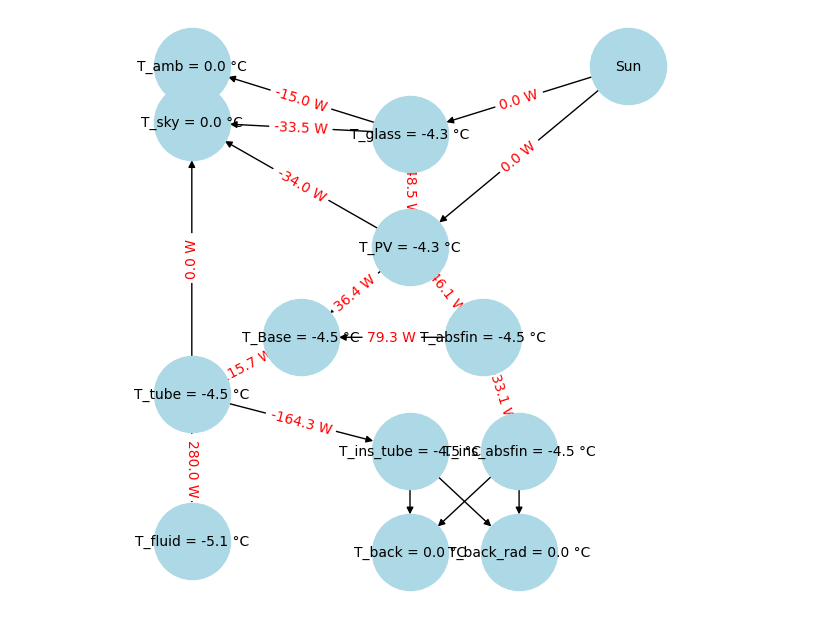

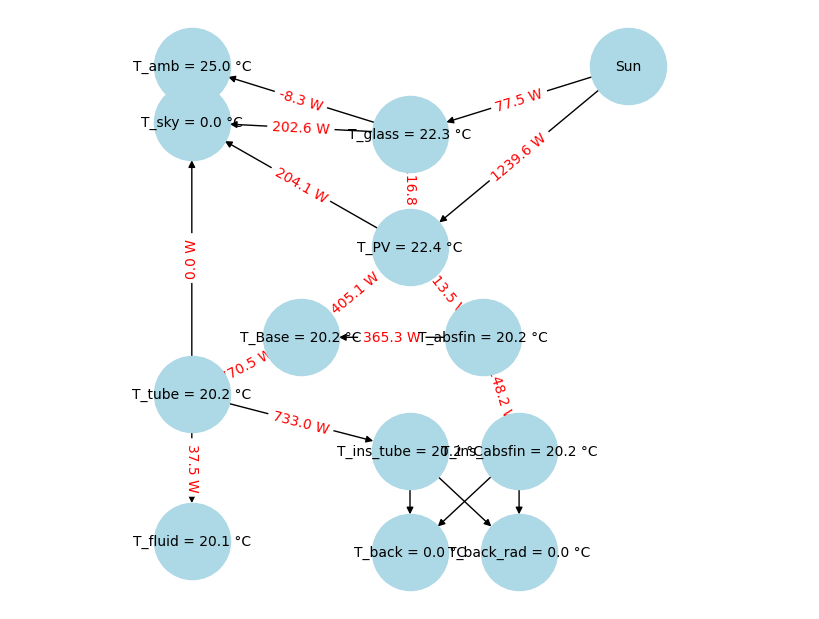

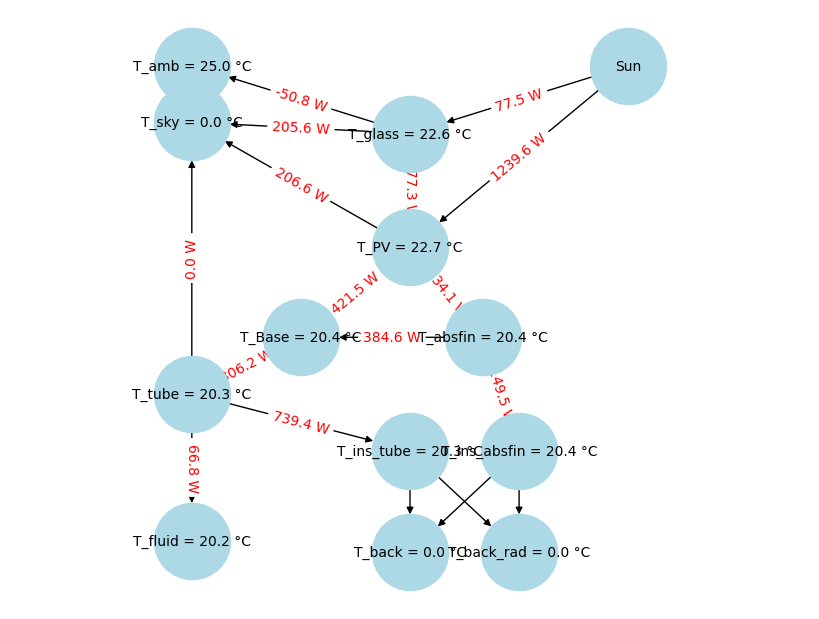

In [33]:
#Crée toutes les pages html des résultats

nb_cases = len(stepConditions)

for case in range(nb_cases) :

    # Récupération de la valeur 'Case' de stepConditions
    case_value = stepConditions[case]['Case']

    df_one,res = ty.simu_one_steady_state_all_he(componentSpecs,stepConditions[case],hyp)

    ## df_one pour chaque résultat
    df_one_html = df_one.to_html()

    ## Résidus
    for part in componentSpecs['decomp'].keys():
        bal,bal_perc = ty.recap_energy_balances(res[part]['df_one'])
        print(part,bal_perc)
    bal,bal_perc = ty.recap_energy_balances(df_one)
    df = pd.DataFrame(bal_perc)
    residus_html = df.to_html()




    ## Graphes noeufs températures et arêtes transferts*
    # First graph does not need to be computed in the loop for

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with labels including temperature
    nodes = ['Sun','T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_Base', 'T_absfin', 
            'T_tube', 'T_fluid', 'T_ins_absfin', 'T_ins_tube', 'T_back', 'T_back_rad']

    nodes_keys = ['Sun','T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_Base_mean', 'T_absfin_mean',
                    'T_tube_mean', 'T_fluid_mean', 'T_ins_absfin_mean', 'T_ins_tube_mean', 'T_back', 'T_back_rad']

    for i,node in enumerate(nodes):
        if node == "Sun":
            G.add_node(node, label=node)
        else:
            G.add_node(node, label=f"{node} = {round(df_one[nodes_keys[i]].iloc[0]-273.15,1)} °C")

    # Add edges with heat transfer labels
    edges = [('Sun','T_glass','Qdot_sun_glass'),('Sun','T_PV','Qdot_sun_PV'),
                ('T_glass', 'T_amb', 'Qdot_top_conv'),('T_glass', 'T_sky', 'Qdot_top_rad'),
                ('T_glass', 'T_PV', 'Qdot_glass_PV'), ('T_PV', 'T_Base', 'Qdot_PV_Base'), ('T_PV', 'T_sky', 'Qdot_PV_sky'),
                ('T_PV', 'T_absfin', 'Qdot_PV_absfin'), ('T_absfin', 'T_Base', 'Qdot_absfin_Base'),
                ('T_Base', 'T_tube', 'Qdot_Base_tube'), ('T_tube', 'T_fluid', 'Qdot_tube_fluid'),('T_tube','T_sky','Qdot_tube_sky'),
                ('T_absfin', 'T_ins_absfin', 'Qdot_absfin_back'),
                ('T_tube', 'T_ins_tube', 'Qdot_tube_back'),
                ('T_ins_absfin', 'T_back', ''),
                ('T_ins_absfin', 'T_back_rad', ''),
                ('T_ins_tube', 'T_back', ''),
                ('T_ins_tube', 'T_back_rad', '')]

    for u, v, label in edges:
        if label == '':
            G.add_edge(u, v)
        else:
            G.add_edge(u, v, label=f"{round(df_one[label].iloc[0],1)} W")

    # Manually set positions based on TikZ coordinates
    pos = {'Sun': (18,0),
            'T_amb': (6, 0),
            'T_sky': (6, -5),
            'T_glass': (12, -6),
            'T_PV': (12, -16),
            'T_Base': (9, -24),
            'T_absfin': (14, -24),
            'T_tube': (6, -29),
            'T_fluid': (6, -42),
            'T_ins_absfin': (15, -34),
            'T_ins_tube': (12, -34),
            'T_back': (12, -43),
            'T_back_rad': (15, -43)
        }

    # Draw the graph with updated node labels
    node_labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    # Création de la figure avec une taille augmentée
    plt.figure(figsize=(8, 6))  # Augmenter la taille selon le besoin

    # Dessin du graphe avec les positions et étiquettes de nœuds personnalisées
    nx.draw(G, pos, labels=node_labels, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Ajustement des limites des axes avec une marge supplémentaire
    ax = plt.gca()  # Obtenir l'objet des axes courants
    ax.set_xlim([min(x for x, _ in pos.values()) - 5, max(x for x, _ in pos.values()) + 5])  # Ajuster selon les valeurs x min et max des positions
    ax.set_ylim([min(y for _, y in pos.values()) - 5, max(y for _, y in pos.values()) + 5])  # Ajuster selon les valeurs y min et max des positions

    # Enregistrer la figure en HTML
    plt.savefig(f'GrapheOrienteNumerique_{case_value}.png', format='png')



    ## Histogramme
    ht_signs = {'Qdot_sun_PV': 1, 'Qdot_sun_glass': 1, 'Qdot_top_conv': -1, 'Qdot_top_rad': -1, 'Qdot_PV_sky': -1, 'Qdot_absfin_back_conv': -1, 'Qdot_absfin_back_rad': -1, 'Qdot_Base_back': -1, 'Qdot_tube_back_conv': -1, 'Qdot_tube_back_rad': -1, 'Qdot_tube_sky': -1}
    ht_labels = ['Qdot_sun_PV', 'Qdot_sun_glass', 'Qdot_top_conv', 'Qdot_top_rad', 'Qdot_PV_sky', 'Qdot_absfin_back_conv', 'Qdot_absfin_back_rad', 'Qdot_Base_back', 'Qdot_tube_back_conv', 'Qdot_tube_back_rad', 'Qdot_tube_sky']
    data = {key: ht_signs[key] * df_one[key].values[0] for key in ht_labels}

    # Création du graphique en barres
    fig = go.Figure()

    # Ajout de chaque barre sur le graphique
    for key, value in data.items():
        fig.add_trace(go.Bar(x=[key], y=[value], name=key))

    # Ajout des annotations sous chaque barre
    for i, key in enumerate(data.keys()):
        fig.add_annotation(
            x=key,
            y=data[key],
            text="",
            showarrow=False,
        )

    # Personnalisation du titre et des étiquettes
    fig.update_layout(
        title="Decomposition of Qdot_tube_fluid in Different Heat Transfer Contributions",
        yaxis_title="Value",
        barmode="group"  # Pour afficher les barres côte à côte
    )

    # Enregistrer le graphique en HTML
    TransfertHTML = pio.write_html(fig, file=f'figure_plotly_{case_value}.html', auto_open=False)


    
    ## Température in, out, mean, PV 
    # Données de température
    Temperature = ['T_fluid_in', 'T_tube_mean', 'T_fluid_out', 'T_PV']
    dataTemp = {key: df_one[key].values[0] - 273.15 for key in Temperature}

    # Création du graphique en barres
    fig = go.Figure()

    # Ajout de chaque barre sur le graphique
    for key, value in dataTemp.items():
        fig.add_trace(go.Bar(x=[key], y=[value], name=key))

    # Ajout des annotations sous chaque barre
    for i, key in enumerate(dataTemp.keys()):
        fig.add_annotation(
            x=key,
            y=dataTemp[key],
            text="",
            showarrow=False,
        )

    # Personnalisation du titre et des étiquettes
    fig.update_layout(
        title="Températures en °C",
        yaxis_title="Température (en°C)",
        barmode="group"  # Pour afficher les barres côte à côte
    )

    # Ajuster la plage de l'axe y pour adapter les barres à l'affichage
    fig.update_yaxes(range=[min(dataTemp.values()) - 5, max(dataTemp.values()) + 5])

    # Enregistrer le graphique en HTML
    TemperatureHTML = pio.write_html(fig, file=f'TemperatureInOutMeanPV_{case_value}.html', auto_open=False)


    
    ## Profil des températures
    # 𝑇𝑓𝑙𝑢𝑖𝑑(𝑦) = (𝑇𝑓𝑙𝑢𝑖𝑑,𝑖𝑛 + 𝑏𝑓/𝑎𝑓) exp(𝑎𝑓 𝑦) − 𝑏𝑓/𝑎𝑓
    a_f = res['main']['slices_df']['a_f']
    b_f = res['main']['slices_df']['b_f']
    T_fluid_in = res['main']['slices_df']['T_fluid_in']
    L_tube = componentSpecs['main']['L_tube']

    def T_fluid_fct(y_values, T_fluid_in, a_f, b_f):
        T_fluid_values = np.zeros(len(y_values))
        i=0
        for y in y_values:
            T_fluid_value = (T_fluid_in + b_f / a_f) * np.exp(a_f * y) - b_f / a_f
            T_fluid_values[i]= T_fluid_value -273.15
            i+=1
        return T_fluid_values

    y_values = np.linspace(0, L_tube, 100)
    T_fluid_values = T_fluid_fct(y_values, T_fluid_in, a_f, b_f)

    # Tracé de la courbe avec Plotly
    fig = go.Figure(go.Scatter(x=y_values, y=T_fluid_values))

    # Ajuster la plage de l'axe y pour adapter les barres à l'affichage
    fig.update_xaxes(range=[0, L_tube])

    # Personnalisation du titre et des étiquettes
    fig.update_layout(title='Profil de température au sein d\'un canal',
                    xaxis_title='Position y',
                    yaxis_title='Température en °C')

    # Enregistrer le graphique en HTML
    ProfilHTML = pio.write_html(fig, file=f'ProfilTemp_{case_value}.html', auto_open=False)

    # Création du fichier HTML pour afficher tous les résultats
    html_content = f"""
    <div style="width: 800px; overflow-x: auto;">
    <!DOCTYPE html>
    <html>
    <head>
        <title>Résultats {case_value}</title>
    </head>
    <body>
        <h1>Résultats : {case_value} </h1>
        <h2>df_one</h2>
        <div style="overflow-x:auto;">
        {df_one_html}
        </div>
        
        <h2>Résidus</h2>
        {residus_html}
        </div>

        <h2>Graphes orientés des transferts</h2>
        <img src="GrapheOriente.png" alt="Graphe des noeuds températures et arêtes transferts">
        <br><br>
        <h2> \n </h2>
        <img src="GrapheOrienteNumerique_{case_value}.png" alt="Graphe des noeuds températures et arêtes transferts">
        <br><br>
        <h2>Histogramme du transfert de chaleur</h2>
        <iframe src="figure_plotly_{case_value}.html" width="800" height="600"></iframe>
        <br><br>
        <h2>Histogramme des température</h2>
        <iframe src="TemperatureInOutMeanPV_{case_value}.html" width="800" height="600"></iframe>
        <br><br>
        <h2>Profil des températures</h2>
        <iframe src="ProfilTemp_{case_value}.html" width="800" height="600"></iframe>
        <br><br>
    </body>
    </html>
    </div>
    """

    # Enregistrer le contenu dans un fichier HTML
    with open(f"resultats_{case_value}.html", 'w') as file:
        file.write(html_content)
    # Ouvrir le fichier HTML dans le navigateur
    #import webbrowser
    #webbrowser.open(f"resultats_{case_value}.html")


In [30]:
#Page HTML qui affiche un menu déroulant pour choisir la page de résultat d'un cas

nb_cases = len(stepConditions) #ça sert à rien de le déclarer de nouveau

# Récupération des valeurs de la colonne 'Case' du dictionnaire stepConditions
case_values = [stepConditions[i]['Case'] for i in range(nb_cases)]

# Génération des options du menu déroulant
options = ''.join([f'<option value="resultats_{case_values[i]}.html">Cas {case_values[i]}</option>' for i, case in enumerate(range(nb_cases))])  

# Création du fichier HTML pour afficher tous les résultats
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Visualisation de fichiers HTML</title>
    <style>
        /* Style CSS pour le centrage et le style du formulaire */
        body {{
            font-family: "Times New Roman", serif;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 50vh;
        }}
        form {{
            display: flex;
            flex-direction: column;
            align-items: center;
        }}
    </style>
</head>
<body>
    <form id="fileForm" action="" method="GET" target="_blank">
        <label for="fileSelect">Sélectionner un fichier à afficher :</label>
        <select id="fileSelect" name="file">
        {options}
        </select>
        <br>
        <input type="submit" value="Valider">
    </form>

    <script>
        // JavaScript pour modifier l'action du formulaire selon le fichier sélectionné
        const fileForm = document.getElementById("fileForm");
        const fileSelect = document.getElementById("fileSelect");

        fileForm.addEventListener("submit", function(event) {{
            // Modifier l'action du formulaire pour ouvrir le fichier sélectionné dans un nouvel onglet
            fileForm.action = fileSelect.value;
        }});
    </script>
</body>
</html>
"""

# Enregistrer le contenu dans un fichier HTML
with open('selection_resultats.html', 'w') as file:
    file.write(html_content)

# Ouvrir le fichier HTML dans le navigateur
import webbrowser
webbrowser.open('selection_resultats.html')


True

Graphiques de groupe

In [16]:
#Graph Qdot_tube_fluid = fct(Delta_T)

# nb_cases = len(stepConditions) #idem ça sert à rien de le redéclarer

Qdot_tube_fluid_list = np.zeros(nb_cases)
DT_list = np.zeros(nb_cases)
u_list = np.zeros(nb_cases)
G_list = np.zeros(nb_cases)
T_amb_list = np.zeros(nb_cases)
Key = nb_cases*[""]

for case in range(nb_cases) :
    df_one,res = ty.simu_one_steady_state_all_he(componentSpecs,stepConditions[case],hyp)
    Qdot_tube_fluid_list[case] = float(res['main']['df_one']['Qdot_tube_fluid'].iloc[0])
    DT_list[case] = float(res['main']['df_one']['T_amb'].iloc[0]) - float(res['main']['df_one']['T_fluid_mean'].iloc[0])
    u_list[case] = float(res['main']['df_one']['u'].iloc[0])
    G_list[case] = float(res['main']['df_one']['G'].iloc[0])
    T_amb_list[case] = float(res['main']['df_one']['T_amb'].iloc[0]) - 273.15
    Key[case] = stepConditions[case]['Case']

# Création d'une liste vide pour stocker les traces
traces = []

# Création d'un dictionnaire pour mapper chaque valeur de u à une couleur spécifique
u_color_mapping = {}

# Création de traces individuelles pour chaque nom dans Key
for i, name in enumerate(Key):
    # Si la valeur de u n'est pas déjà présente dans le dictionnaire, ajoutez-la avec une nouvelle couleur
    if u_list[i] not in u_color_mapping:
        u_color_mapping[u_list[i]] = 'rgb({}, {}, {})'.format(
            np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
      
    trace = go.Scatter(
        x=[DT_list[i]],  # Coordonnées x
        y=[Qdot_tube_fluid_list[i]],  # Coordonnées y
        mode='markers',
        name="",  # Nom de la trace
        showlegend=False,  # Ne pas afficher la légende
        hoverinfo='name',  # Afficher uniquement le nom de la trace au passage de la souris
        marker=dict(color=u_color_mapping[u_list[i]]),  # Couleur des points
        hovertemplate=name+ #Composition des étiquettes pour chaque point
        '<br> G = '+str(G_list[i])+' W'+
        '<br> T_amb = '+str(T_amb_list[i])+' °C'+
        '<br> u = {:.2f}'.format(u_list[i])+' m/s'
    )
    traces.append(trace)


# Création de la figure à partir des traces
fig = go.Figure(data=traces)

# Personnalisation du titre et des étiquettes
fig.update_layout(
    title='Flux de chaleur du tube vers le fluide en fonction de la différence de température',
    xaxis_title='Différence entre la température ambiante et celle du fluide',
    yaxis_title='Flux de chaleur',
)


fig.show()

# Enregistrer le graphique en HTML
#ProfilHTML = pio.write_html(fig, file='ProfilTemp.html', auto_open=True)

In [15]:
# Création d'une liste vide pour stocker les traces
traces = []
legend_trace = []

# Création d'un dictionnaire pour mapper chaque valeur de u à une couleur spécifique
u_color_mapping = {}

# Création de traces individuelles pour chaque nom dans Key
for i, name in enumerate(Key):
    # Si la valeur de u n'est pas déjà présente dans le dictionnaire, ajoutez-la avec une nouvelle couleur
    if u_list[i] not in u_color_mapping:
        u_color_mapping[u_list[i]] = 'rgb({}, {}, {})'.format(
            np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
      
    trace = go.Scatter(
        x=[DT_list[i]],  # Coordonnées x
        y=[Qdot_tube_fluid_list[i]],  # Coordonnées y
        mode='markers',
        name="",  # Nom de la trace
        showlegend=False,  # Ne pas afficher la légende
        hoverinfo='name',  # Afficher uniquement le nom de la trace au passage de la souris
        marker=dict(color=u_color_mapping[u_list[i]]),  # Couleur des points
        hovertemplate=name+ #Composition des étiquettes pour chaque point
        '<br> G = '+str(G_list[i])+' W'+
        '<br> T_amb = '+str(T_amb_list[i])+' °C'+
        '<br> u = {:.2f}'.format(u_list[i])+' m/s'
    )
    traces.append(trace)



# Création de la figure à partir des traces
fig = go.Figure(data=traces)
for i, u in enumerate(u_color_mapping[u_list[i]]) :
    legend= go.Scatter(x=[u_color_mapping[u_list[i]]],
                            y=[i],
                            mode="markers",
                            line=go.scatter.Line(color="gray"),
                            marker=dict(color=u_color_mapping[u_list[i]]),
                            showlegend=True)
    fig.add_trace(legend)
    legend_trace.append(legend)


# Personnalisation du titre et des étiquettes
fig.update_layout(
    title='Flux de chaleur du tube vers le fluide en fonction de la différence de température',
    xaxis_title='Différence entre la température ambiante et celle du fluide',
    yaxis_title='Flux de chaleur',
)


fig.show()

NameError: name 'Key' is not defined